In [1]:
import torch.nn as nn
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from transformer import SpaceTimeFormer

In [17]:
def download_data(TICKER, START_DATE, END_DATE):
    data = yf.download(TICKER, start= START_DATE, end = END_DATE)
    data = data['Close']
    #data = pd.DataFrame(data)
    return data

date_start = '2021-01-03'
date_end = '2022-12-03'

#Stocks
ticker = {
    'DJ': 'DJI',
    'UnitedHealth Group': 'UNH',
    'Goldman Sachs': 'GS',
    'Home Depot': 'HD',
    'Amgen': 'AMG',
    'McDonalds': 'MCD',
    'Microsoft': 'MSFT'
}

#load data
df = pd.concat([download_data(name, date_start, date_end) for name in ticker.values()], axis=1)

#rename columns
df.set_axis([name for name in ticker.keys()], axis=1, copy=True)

#calculate returns
df = df.pct_change(1)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna().to_numpy().transpose()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [18]:
np.shape(df)

(7, 483)

In [80]:
sequence_souce = df[1:, :]
sequence_target = df[0, :].reshape(1,-1)

In [85]:
split = 0.7
pred_window = 1
seq_length = 5
sequence_source_train = sequence_souce[:, :int(np.shape(sequence_souce)[1]*split)]
sequence_source_test = sequence_souce[:, int(np.shape(sequence_souce)[1]*split):]
sequence_target_train = sequence_target[:, :int(np.shape(sequence_target)[1]*split)]
sequence_target_test = sequence_target[:, int(np.shape(sequence_target)[1]*split):]

In [99]:
model = SpaceTimeFormer(pred_offset = pred_window,
                        input_size = 6,
                        output_size = 1,
                        seq_length = seq_length,
                        embedding_size_time = 3,
                        embedding_size_variable = 10)

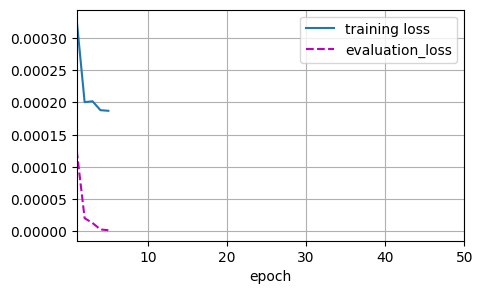

In [100]:
model.start_training(source=sequence_source_train,
                     target=sequence_target_train,
                     loss=nn.MSELoss(),
                     metric=nn.MSELoss(),
                     epochs=50,
                     batch_size=64,
                     learning_rate=1e-3,
                     standardize=True,
                     verbose=False,
                     plot=True)

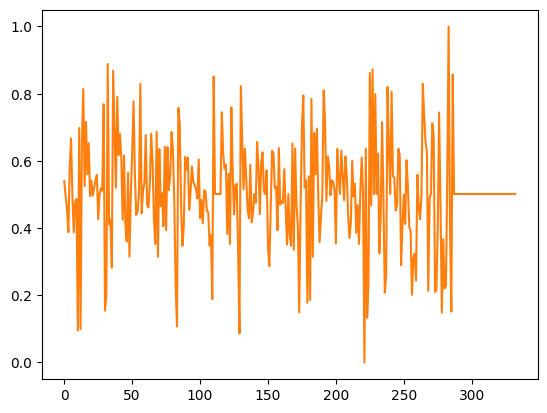

In [101]:
standardize = True
source = sequence_source_train
target = sequence_target_train

if standardize:
    scaler = preprocessing.MinMaxScaler().fit(source.transpose())
    source = scaler.transform(source.transpose()).transpose()
    scaler = preprocessing.MinMaxScaler().fit(target.transpose())
    target = scaler.transform(target.transpose()).transpose()

l = np.shape(sequence_source_train)[1]
y_hat = np.zeros((1,l))
y = target

src_idx_1, src_idx_2 = 0, 0
trg_idx_1, trg_idx_2 = 1, 1

while trg_idx_2 < l:
    src_idx_2 = src_idx_1 + seq_length
    trg_idx_2 = trg_idx_1 + seq_length + pred_window - 1
    
    src = source[:, src_idx_1:src_idx_2]
    trg_stub = target[:, trg_idx_1:trg_idx_2-pred_window]
    y_hat[0, trg_idx_2-pred_window:trg_idx_2] = model.predict(src, trg_stub, False)
    
    src_idx_1 += pred_window
    trg_idx_1 += pred_window

plt.plot(y_hat[0,seq_length:])
plt.plot(y[0,seq_length:])
plt.show()